# Lab1 - Introduction + Neural Networks + PyTorch recap

## Plan for today

1. Get to know course rules, timetable, etc.
2. Briefly recap our ML knowledge:
    * implement basic logistic regression from scratch
    * get (re)accustomed with PyTorch

## 1. Course logistics

Let's go over [the course page](https://github.com/gmum/wzum-22) on GitHub.

## 2. Logistic regression from scratch

We will tackle the problem of **classification**, i.e. prediction of a discrete value (class):

$$
f(x) = y, y \in \{0...N\}
$$

The most basic variant of this is **binary** classification: $y \in \{0, 1\}$. We will focus on that for the time being.

**Logistic regression** is a model which predicts the probability that a given example belongs to the class 1:

$$
g(x) = \hat{p}(y = 1 | x )
$$

**Questions for you:**
* what is the probability that $y=0$?
* in the multi-class case, how many outputs will the model have?
* what conditions must the model outputs satisfy?

As an example, we will work with a breast cancer prediction dataset.

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from typing import Tuple
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [23]:
print(load_breast_cancer().DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [24]:
np.random.seed(0)
X, y = load_breast_cancer(return_X_y=True)
X_train, X_val, y_train, y_val= train_test_split(X, y, train_size=0.9)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


print("array shapes", [t.shape for t in [X_train, X_val, y_train, y_val]])
print("y values", np.unique(y_train), np.unique(y_val) )

array shapes [(512, 30), (57, 30), (512,), (57,)]
y values [0 1] [0 1]



### Linear vs logistic regression

We need to transform a vector of 30 features into a value $\in (0,1)$. Can we use linear regression for that?

![classification_regression](https://raw.githubusercontent.com/aghbit/BIT_AI/master/3_logistic_regression/img/clas_reg.png)

Recall that in linear regression $f(x) \in \mathbb{R} $ is defined as:
$$
f(x) = w^T x + b
$$

Where $w, b$ are trainable parameters.

In logistic regression, we will need to squash the output, so that $f(x) \in [0,1]$. A convenient way to do this is the **sigmoid** function:

$$\sigma(x) = \frac{1}{1+e^{-x}}$$

sigmoid(-inf) = 0.0
sigmoid(0) = 0.5
sigmoid(1) = 0.7310585786300049
sigmoid(inf) = 1.0


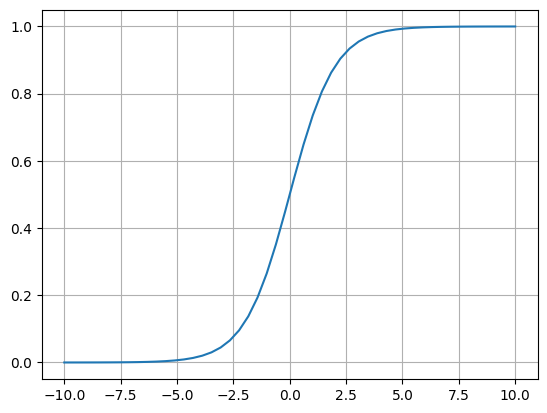

In [25]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

for x in [
   -np.inf,
    0,
    1,
    np.inf
]:
    print(f"sigmoid({x}) = {sigmoid(x)}")

x = np.linspace(-10, 10)

plt.plot(x, sigmoid(x))
plt.grid(True)
plt.show()

To sum it up, in case of binary classification:
$$
\hat{p}(y=1 | x) = \sigma(w^Tx + b)
$$

What about the loss function which can train such a model?

We'll use a logarithmic loss function which quite nicely captures an intuition, that we want the predictions datapoints which should be predicted as $0$ as close to $0$ as possible, and, analogically, predictions which should be $1$, as close to $1$ as possible:

$$ L = \frac{-1}{n}\Big(\sum_{i=0}^n y^{(i)}\log{f(x^{(i)})} + (1-y^{(i)})\log{(1-f(x^{(i)}))} \Big)$$

This function is called **Binary Cross-Entropy**

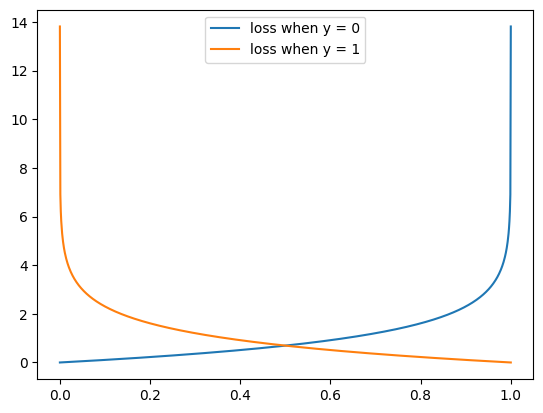

In [26]:
x = np.linspace(1e-6, 1 - (1e-6), 1000)

plt.plot(x, -np.log(1 - x), label="loss when y = 0")
plt.plot(x, -np.log(x), label="loss when y = 1")
plt.legend()
plt.show()

### Task for you: implement the binary cross-entropy function.

In [27]:
def binary_cross_entropy(x, y, w, b) -> float:
    z = sigmoid(np.matmul(x, w)+b)
    return (np.matmul(y, np.log(z))+np.matmul(1-y, np.log(1-z)))*(-1)//len(x)

In [28]:
#l_train = binary_cross_entropy(X_train, y_train, w=w, b=b)

In order to train the parameters $w, b$ of our model, we need to calculate the gradients of loss with regard to those parameters:

$$ \frac{\partial L}{\partial w} \text{ and } \frac{\partial L}{\partial b} $$


### Task for you: implement the function which calculates $\frac{\partial L}{\partial w}$ and $\frac{\partial L}{\partial b}$:

In [29]:
def calculate_gradients(x, y, w, b) -> Tuple[np.ndarray, np.ndarray]:    
    w_grad = 1/len(x)*(np.matmul((sigmoid(np.matmul(x, w)+b)-y.reshape(len(y), 1)).transpose(), x)).transpose()
    b_grad = 1/len(x)*np.sum((sigmoid(np.matmul(x, w)+b)-y.reshape(len(y), 1)).transpose())
    return (w_grad, b_grad)

With the gradient calculation implemented, we should be able to train our model with the **Gradient Descent** method.

With a good choice of learning rate, you should be able to achieve around 90% validation accuracy.

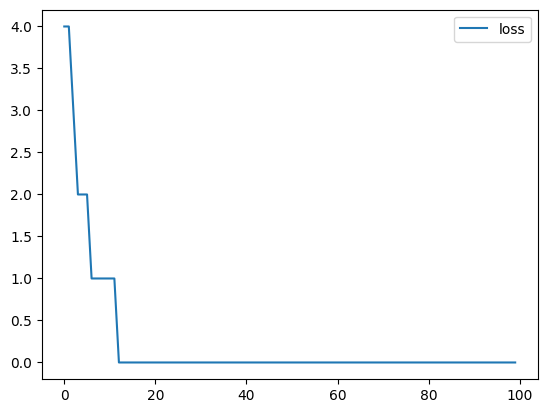

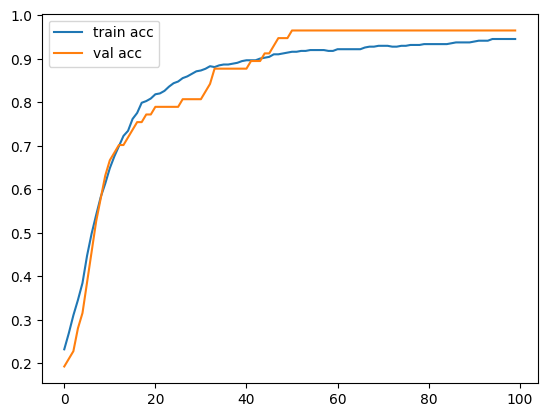

In [30]:
w = np.random.randn(30, 1) 
b = np.random.randn(1)
# how should we initialize w and b?

lr = 1e-1
# how big should be the learning rate?

history = []

for epoch in range(100):
    
    y_pred_train = sigmoid(np.matmul(X_train, w)+b)# calculate predictions based on x, w, and b (don't forget sigmoid!)
    y_pred_train = (y_pred_train > 0.5).astype(int)
    train_accuracy = (y_pred_train.reshape(-1) == y_train).mean()
    
    y_pred_val = sigmoid(np.matmul(X_val, w)+b) # calculate predictions based on x, w, and b (don't forget sigmoid!)
    y_pred_val = (y_pred_val > 0.5).astype(int)
    val_accuracy = (y_pred_val.reshape(-1) == y_val).mean()
    
    l_train = binary_cross_entropy(X_train, y_train, w=w, b=b)
    dw, db = calculate_gradients(X_train, y_train, w=w, b=b)

    w = w - lr*dw  # assign new value of w based on gradient dw
    b = b - lr*db # assign new value of b based on gradient db
    
    elem = dict(epoch=epoch, loss=l_train, train_accuracy=train_accuracy, val_accuracy=val_accuracy)
    history.append(elem)

plt.plot([h["epoch"] for h in history], [h["loss"] for h in history], label="loss")
plt.legend()
plt.show()

plt.plot([h["epoch"] for h in history], [h["train_accuracy"] for h in history], label="train acc")
plt.plot([h["epoch"] for h in history], [h["val_accuracy"] for h in history], label="val acc")
plt.legend()
plt.show()

## 3. Logistic regression with PyTorch automatic differentiation / loss / optimization tools

In [31]:
from torch.optim import SGD
from torch import nn
import torch

### Task for you: initialize a logistic regression PyTorch model and train it

You should achieve around 90% validation accuracy.

In [32]:
model = nn.Sequential(
    nn.Linear(30, 1),
    nn.Sigmoid()
    # we need a sequence of two pytorch layers for a basic logistic regression model - which ones?
)
opt = SGD(model.parameters(), lr=1e-1)
loss_fn = nn.BCELoss()

print({
    name: p.shape
    for (name, p) in model.named_parameters()
})

{'0.weight': torch.Size([1, 30]), '0.bias': torch.Size([1])}


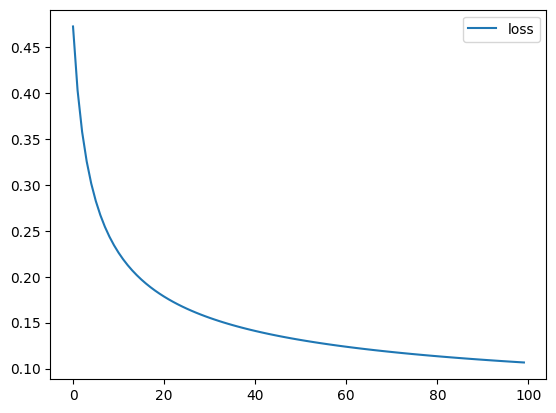

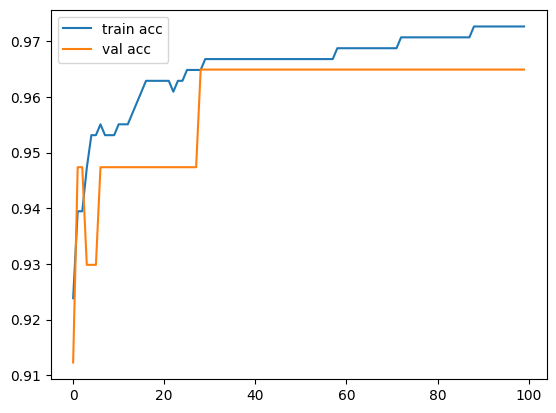

In [33]:
history = []

X_train = torch.tensor(X_train).type(torch.FloatTensor)

X_val = torch.tensor(X_val).type(torch.FloatTensor)
y_train = (torch.tensor(y_train)).type(torch.FloatTensor)
y_val = (torch.tensor(y_val)).type(torch.FloatTensor)


for epoch in range(100):
    opt.zero_grad()
    
    ### YOUR CODE HERE ###
    y_pred_train = model(X_train).squeeze() # make predictions for train set
    
    y_pred_val = model(X_val).squeeze() # make_predictions for val set
    
    #print(y_train.size())
    #print(y_pred_train)
    #print(y_train)

    # calculate loss
    l_train = loss_fn(y_pred_train, y_train)
    #print(l_train)
    l_train.backward()
    opt.step()
    # calculate gradients with respect to l_train
    
    # perform the optimization step with the optimizer
    
    #######################
    predictions = (y_pred_train.detach().numpy() > 0.5)
    
    train_accuracy = (predictions == y_train.detach().numpy()).mean()
    
    val_predictions = (y_pred_val.detach().numpy() > 0.5)

    val_accuracy = (val_predictions == y_val.detach().numpy()).mean()

    elem = dict(epoch=epoch, loss=l_train.item(), train_accuracy=train_accuracy, val_accuracy=val_accuracy)
    history.append(elem)
    


    
plt.plot([h["epoch"] for h in history], [h["loss"] for h in history], label="loss")
plt.legend()
plt.show()

plt.plot([h["epoch"] for h in history], [h["train_accuracy"] for h in history], label="train acc")
plt.plot([h["epoch"] for h in history], [h["val_accuracy"] for h in history], label="val acc")
plt.legend()
plt.show()

## 4. FashionMNIST: a bigger task

Let's now train a neural net on a more challenging, multi-label FashionMNIST task.

In [34]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms as tv
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

### Task: load the dataset and visualize some examples along with their classes
* what is the shape of a single example from the dataset?

In [35]:
ds = FashionMNIST('./data', train=True, target_transform=None, download=True, transform=tv.ToTensor()) # transform the data from PIL image to a tensor
ds_test = FashionMNIST('./data', train=False, target_transform=None, download=True, transform=tv.ToTensor()) # transform the data from PIL image to a tensor

In [36]:
# visualize 10 examples from the dataset, along with their class numbers

In [37]:
batch_size=64

train_dl = DataLoader(ds, batch_size, shuffle=True)
valid_dl = DataLoader(ds_test, batch_size, shuffle=True)

### Task: implement and train a neural network with two linear layers and ReLU activation between them. 

You should achieve at least 80% validation accuracy.

In [38]:
class FashionNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        # initialize the layers of the network
        # what is the size of the input?
        # what is the output size?
        
    def forward(self, x):
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x
        # process x through:
        # 1) first layer
        # 2) relu activation
        # 3) second layer

In [39]:
net = FashionNN() # actually initialize the net
loss_fn = nn.CrossEntropyLoss() # what loss do we use for multilabel classification?
opt = torch.optim.Adam(net.parameters())

In [ ]:
number_of_epochs = 10

for i in range(number_of_epochs):
    train_loss = 0
    for iteration, (X_train, y_train) in enumerate(train_dl):
        
        opt.zero_grad()

        # perform optimization on the train set and calculate the total train loss
        X_train = X_train.view(X_train.size(0), -1)

        predictions = net(X_train)

        loss = loss_fn(predictions, y_train)
        loss.backward()
        train_loss += loss.item()
        opt.step()

        
        
    val_loss = 0
    y_predicted = []
    y_true = []

    with torch.no_grad():
        for iteration, (X_val, y_val) in enumerate(valid_dl):
            # perform predictions on the validation set and gather them to calculate accuracy
            X_val = X_val.view(X_val.size(0), -1)
            y_pred = net(X_val)
            loss = loss_fn(y_pred, y_val)
            val_loss += loss.item()
            y_pred = y_pred.argmax(dim=1)
            y_true.extend(y_val.numpy())
            y_predicted.extend(y_pred.numpy())
    
            
    val_acc = accuracy_score(y_true, y_predicted)
    print(f'#Epoch: {i}, train loss: {train_loss}, val loss: {val_loss}, val_acc: {val_acc}')
    